# Calculate weighted APO:ffCO2 ratios

The weighted ratio at one time step (t) for one grid cell (j) is calculated by:

$R_{t, \delta APO:CO_2} = \frac{1}{\sum^n_{j=0}fp_{t,j}} \sum^n_{j=0}(\alpha_{Ft,j}-\alpha_L) fp_{t,j}$

### We can do this for

- multiple inventories,
- either the APO:ffCO2 or oxidative ratios
- a single month or a whole year.

In [1]:
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

from acrg.name import name

sys.path.append(os.environ['FUNCS'])
import han_func

In [2]:
year = 2014
month = 'all'

ratio_gas = 'Oxidative' # 'APO' #

site = 'WAO'
ox_ratio_inv = ['gridfed-ukghg'] #, 'gridfed']

alpha_l = 1.07

start_month = 1 if month=='all' else month
time_diff = relativedelta(years=1) if month=='all' else relativedelta(months=1)
start = datetime(year, start_month, 1)
end = start + time_diff

## Get the weighted footprints

### Get the footprints

In [3]:
footprint = name.footprints(site, met_model='UKV',
                            start = start,
                            end = end,
                            domain = 'EUROPE',
                            chunks = {'time': 50},
                            species = 'co2')

Reading and concatenating files: 
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201401.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201402.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201403.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201404.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201405.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201406.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201407.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201408.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201409.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201410.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201411.nc
/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/WAO-20magl_UKV_co2_EUROPE_201412.nc


### Weight the footprints

In [4]:
fp_total = footprint.fp.sum(dim=['lat', 'lon'])
fp_ratio = footprint.fp / fp_total

## Weight the ratios

### Get the oxidative ratios

In [5]:
oxidative_ratio_ds = {inv: name.flux(domain = 'EUROPE',
                                     species = f'oxidativeratio-{inv}-1hr',
                                     start = start,
                                     end = end,
                                     chunks = {'time': 50})
                      for inv in ox_ratio_inv}


Searching for flux files: /group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_*.nc
Reading and concatenating files: 
/group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_EUROPE_2014.nc
/group/chemistry/acrg/LPDM/emissions/EUROPE/oxidativeratio-gridfed-ukghg-1hr_EUROPE_2015.nc
Slicing time to range 2014-01-01 00:00:00 - 2014-12-31 23:59:59


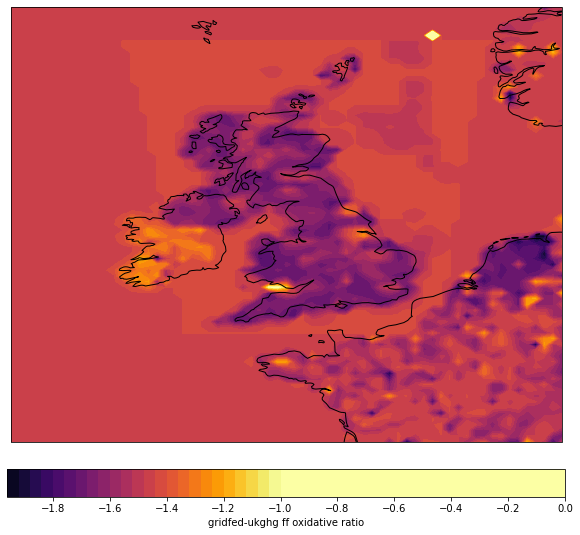

In [6]:
oxidative_ratio_data = [ox.flux[:,:,0] for ox in oxidative_ratio_ds.values()]
oxidative_ratio_labels = [f'{inv} ff oxidative ratio' for inv in oxidative_ratio_ds.keys()]
ax = han_func.show_map(data = oxidative_ratio_data,
                       crop_uk = True,
                       colorbar_label_kwargs={'label': oxidative_ratio_labels},
                       im_kwargs={'vmin':-2, 'vmax':-1})

### Weight the ratios

If calculating weighted APO:ffCO2 ratios we add on the biospheric oxidative ratio

Then we multiply by the weighted footprints to weight the ratios

Calculating Oxidative ratio


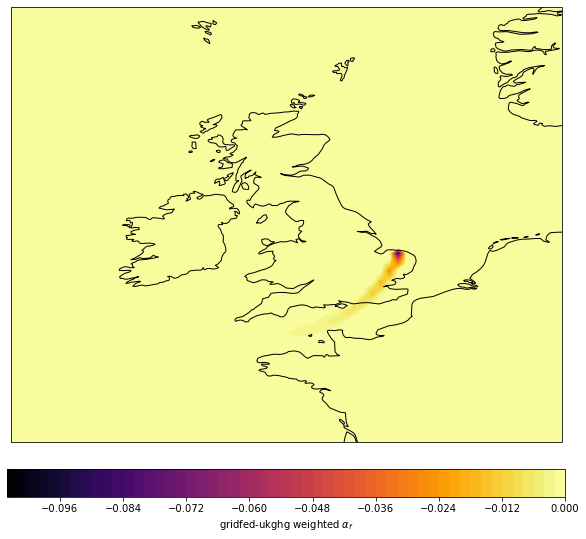

In [7]:
for ratio in oxidative_ratio_ds.values():
    for ll in ['lat', 'lon']:
        ratio[ll] = fp_ratio[ll]
        
print(f'Calculating {ratio_gas} ratio')
oxidative_ratio_weighted = {inv: (ratio.flux + alpha_l) * fp_ratio if ratio_gas=='APO' else ratio.flux * fp_ratio
                            for inv, ratio in oxidative_ratio_ds.items()}

data = [oxratio[:,:,0] for oxratio in oxidative_ratio_weighted.values()]
labels = [f'{inv} weighted '+r'$\alpha_f$' for inv in oxidative_ratio_weighted.keys()]
ax = han_func.show_map(data = data,
                       crop_uk = True,
                       coast_color='black',
                       colorbar_label_kwargs={'label': labels})

In [8]:
oxidative_ratio_weighted_total = {inv: (ratio).sum(dim=['lat', 'lon'])
                                      for inv, ratio in oxidative_ratio_weighted.items()}

## Save the timeseries

### Create attributes

In [9]:
prior_attrs = {inv: {f'prior_{key.split("prior_")[-1]}': attr
                     for key, attr in ox_ratio_ds.attrs.items()}
               for inv, ox_ratio_ds in oxidative_ratio_ds.items()}
fp_attrs = {f'fp_{key.split("fp_")[-1]}': attr for key, attr in footprint.attrs.items()}

all_attrs = {inv: {**fp_attrs, **prior_attrs_inv} for inv, prior_attrs_inv in prior_attrs.items()}

### Save to netcdf

- Put the ratio timeseries into an xarray dataset and assign the attributes created above
- Then save the dataset as a netcdf file

In [10]:
oxidative_ratio_ts_ds = {inv: ox_ratio_inv.to_dataset(name=f'{ratio_gas.lower()}_ratio').compute()
                         for inv, ox_ratio_inv in oxidative_ratio_weighted_total.items()}
oxidative_ratio_ts_ds = {inv: ox_ratio_inv.assign_attrs(all_attrs[inv])
                         for inv, ox_ratio_inv in oxidative_ratio_ts_ds.items()}

datestr = year if month=='all' else f'{year}{str(month).zfill(2)}'
filenames = {inv: os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'OxidativeRatio',
                               f'Weighted{ratio_gas}Ratio-{inv}_timeseries_{datestr}.nc')
             for inv in ox_ratio_inv}

for inv, ox_ratio_ds in oxidative_ratio_ts_ds.items():
    print(f'Saving to {filenames[inv]}')
    ox_ratio_ds.to_netcdf(filenames[inv])


In [ ]:
show = False
if show==True:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6), sharex=True)
    plots = [ratio.plot(ax=ax, label=inv) for inv, ratio in oxidative_ratio_weighted_total.items()]
    ylabel = ax.set_ylabel(r'Weighted $\alpha_F$', fontsize=14)
    xlabel = ax.set_xlabel('')
    legend = ax.legend(loc='best')